In [1]:
import numpy as np
import pandas as pd

In [2]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 282, done.
remote: Counting objects: 100% (282/282), done.
remote: Compressing objects: 100% (207/207), done.
remote: Total 3127 (delta 118), reused 223 (delta 75), pack-reused 2845
Receiving objects: 100% (3127/3127), 573.06 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (1222/1222), done.
Checking out files: 100% (969/969), done.


In [3]:
df = pd.read_csv('./covid-chestxray-dataset/metadata.csv')

In [4]:
df.head()

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
2,2,5,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 27, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-c-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
3,2,6,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 28, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-d-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
4,4,0,F,52.0,COVID-19,NaN,N,N,N,N,N,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Changhua Christian Hospital, Changhua City, Ta...",images,nejmc2001573_f1a.jpeg,10.1056/NEJMc2001573,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,diffuse infiltrates in the bilateral lower lungs,NaN,NaN


In [5]:
selected_df = df[df.finding=="COVID-19"]

In [6]:
selected_df = selected_df[(selected_df.view == "AP") | (selected_df.view == "PA")]

In [7]:
selected_df.head(2)

,patientid,offset,sex,age,finding,survival,intubated,intubation_present,went_icu,in_icu,needed_supplemental_O2,extubated,temperature,pO2_saturation,leukocyte_count,neutrophil_count,lymphocyte_count,view,modality,date,location,folder,filename,doi,url,license,clinical_notes,other_notes,Unnamed: 28
0,2,0,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 22, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-a-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN
1,2,3,M,65.0,COVID-19,Y,N,N,N,N,Y,NaN,NaN,NaN,NaN,NaN,NaN,PA,X-ray,"January 25, 2020","Cho Ray Hospital, Ho Chi Minh City, Vietnam",images,auntminnie-b-2020_01_28_23_51_6665_2020_01_28_...,10.1056/nejmc2001272,https://www.nejm.org/doi/full/10.1056/NEJMc200...,NaN,"On January 22, 2020, a 65-year-old man with a ...",NaN,NaN


In [8]:
images = selected_df.filename.values.tolist()

In [9]:
import os
import shutil

os.makedirs('./COVID19-DATASET/train/covid19')
os.makedirs('./COVID19-DATASET/train/normal')

In [10]:
COVID_PATH = './COVID19-DATASET/train/covid19'
NORMAL_PATH = './COVID19-DATASET/train/normal'

In [11]:
for image in images:
    shutil.copy(os.path.join('./covid-chestxray-dataset/images', image), os.path.join(COVID_PATH, image))

In [12]:
os.environ['KAGGLE_USERNAME'] = "arunrk7" # username from the json file
os.environ['KAGGLE_KEY'] = "25dbb2e10820d88ba10574246a9b83dd"

In [13]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.28G/2.29G [00:42<00:00, 64.3MB/s]
100% 2.29G/2.29G [00:42<00:00, 57.8MB/s]


In [14]:
!unzip -q chest-xray-pneumonia.zip

In [15]:
for image in os.listdir('./chest_xray/train/NORMAL')[:300]:
    shutil.copy(os.path.join('./chest_xray/train/NORMAL', image), os.path.join(NORMAL_PATH, image))

In [16]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler

import matplotlib.pyplot as plt
import time
import copy

import tqdm.notebook as tqdm

import sklearn
from sklearn.metrics import roc_auc_score, accuracy_score, cohen_kappa_score
from PIL import Image

In [17]:
DATA_PATH = './COVID19-DATASET/train'

In [18]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.RandomRotation(10),
                                transforms.RandomHorizontalFlip(p=0.4),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), 
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [19]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train'])
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8)
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['covid19', 'normal']


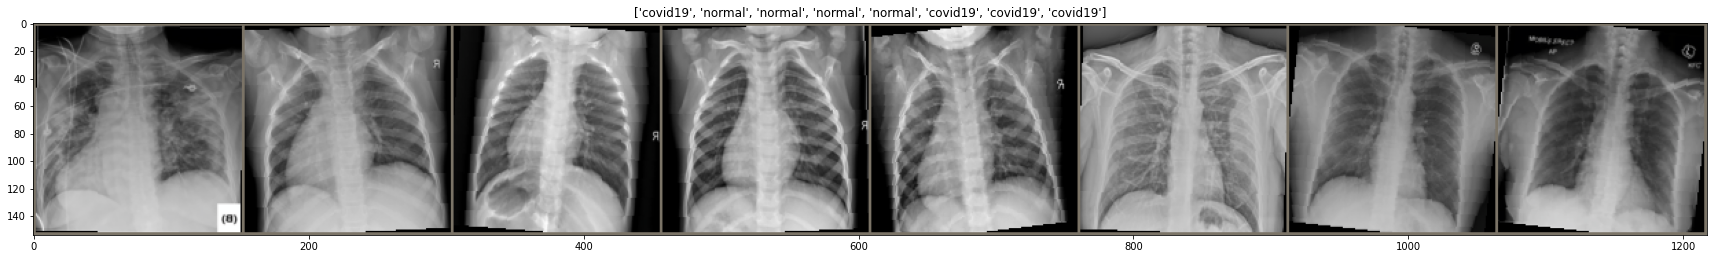

In [20]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
torch.cuda.empty_cache()

In [69]:
def CNN_Model(pretrained=True):
    model = models.densenet121(pretrained=True)
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, len(class_names))
    model = model.to(device)
    return model

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [70]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
6955906


In [71]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm.tqdm(dataloaders[phase], desc=phase, leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    scheduler.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [72]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [73]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)


Epoch 1/20
----------


train Loss: 0.1680 | train Accuracy: 0.9356


val Loss: 0.0515 | val Accuracy: 0.9917 | Kappa Score: 0.9833
Val loss Decreased from inf to 0.0515 
Saving Weights... 

Epoch 2/20
----------


train Loss: 0.1215 | train Accuracy: 0.9584


val Loss: 0.0191 | val Accuracy: 1.0000 | Kappa Score: 1.0000
Val loss Decreased from 0.0515 to 0.0191 
Saving Weights... 

Epoch 3/20
----------


train Loss: 0.1920 | train Accuracy: 0.9314


val Loss: 0.0177 | val Accuracy: 0.9917 | Kappa Score: 0.9810
Val loss Decreased from 0.0191 to 0.0177 
Saving Weights... 

Epoch 4/20
----------


train Loss: 0.1197 | train Accuracy: 0.9605


val Loss: 0.0204 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 5/20
----------


train Loss: 0.1395 | train Accuracy: 0.9543


val Loss: 0.0209 | val Accuracy: 0.9917 | Kappa Score: 0.9733

Epoch 6/20
----------


train Loss: 0.1125 | train Accuracy: 0.9605


val Loss: 0.0193 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 7/20
----------


train Loss: 0.0995 | train Accuracy: 0.9626


val Loss: 0.0243 | val Accuracy: 0.9917 | Kappa Score: 0.9810

Epoch 8/20
----------


train Loss: 0.1788 | train Accuracy: 0.9293


val Loss: 0.0199 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 9/20
----------


train Loss: 0.1753 | train Accuracy: 0.9501


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:604: RuntimeWarning: invalid value encountered in true_divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.0250 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 10/20
----------


train Loss: 0.1045 | train Accuracy: 0.9584


val Loss: 0.0260 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 11/20
----------


train Loss: 0.1183 | train Accuracy: 0.9522


val Loss: 0.0264 | val Accuracy: 1.0000 | Kappa Score: 1.0000

Epoch 12/20
----------


train Loss: 0.1118 | train Accuracy: 0.9584


val Loss: 0.0250 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 13/20
----------


train Loss: 0.0892 | train Accuracy: 0.9730


val Loss: 0.0224 | val Accuracy: 0.9917 | Kappa Score: 0.9333

Epoch 14/20
----------


train Loss: 0.1043 | train Accuracy: 0.9605


val Loss: 0.0203 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 15/20
----------


train Loss: 0.1385 | train Accuracy: 0.9480


val Loss: 0.0310 | val Accuracy: 0.9917 | Kappa Score: 0.9733

Epoch 16/20
----------


train Loss: 0.1553 | train Accuracy: 0.9480


val Loss: 0.0177 | val Accuracy: 0.9917 | Kappa Score: 0.9833
Val loss Decreased from 0.0177 to 0.0177 
Saving Weights... 

Epoch 17/20
----------


train Loss: 0.1306 | train Accuracy: 0.9522


val Loss: 0.0331 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 18/20
----------


train Loss: 0.1404 | train Accuracy: 0.9522


val Loss: 0.0268 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 19/20
----------


train Loss: 0.0897 | train Accuracy: 0.9688


val Loss: 0.0259 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Epoch 20/20
----------


train Loss: 0.0979 | train Accuracy: 0.9709


val Loss: 0.0268 | val Accuracy: 0.9917 | Kappa Score: 0.9833

Training complete in 13m 7s
Best val loss: 0.0177


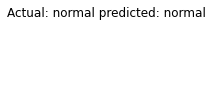

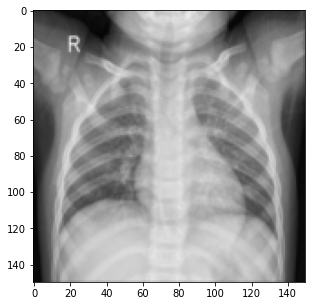

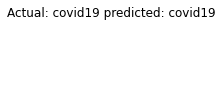

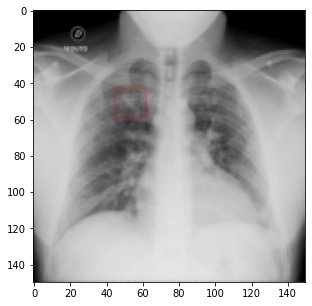

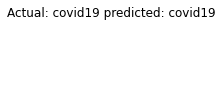

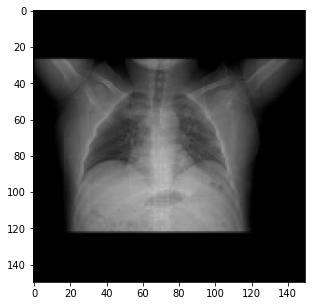

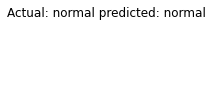

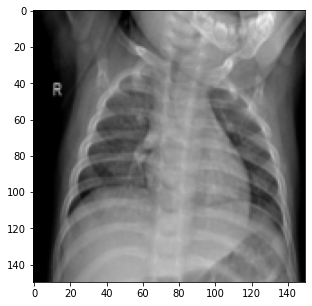

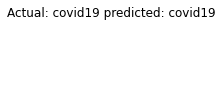

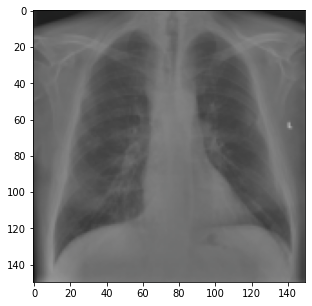

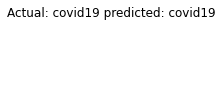

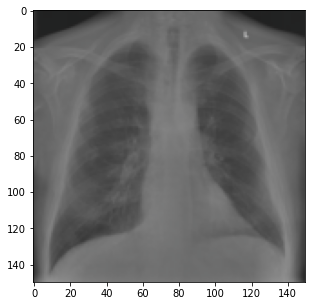

In [74]:
visualize_model(base_model)
plt.show()

In [75]:
os.makedirs('./COVID19-DATASET/test/covid19')
os.makedirs('./COVID19-DATASET/test/normal')

In [76]:
! kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 99% 1.14G/1.15G [00:24<00:00, 34.6MB/s]
100% 1.15G/1.15G [00:24<00:00, 50.2MB/s]


In [77]:
!unzip -q covid19-radiography-database.zip

In [78]:
COVID_TEST = './COVID-19 Radiography Database/COVID-19'
NORMAL_TEST = './COVID-19 Radiography Database/NORMAL'

for image in os.listdir(COVID_TEST)[:100]:
    shutil.copy(os.path.join(COVID_TEST, image), os.path.join('./COVID19-DATASET/test/covid19', image))
for image in os.listdir(NORMAL_TEST)[:100]:
    shutil.copy(os.path.join(NORMAL_TEST, image), os.path.join('./COVID19-DATASET/test/normal', image))

In [79]:
TEST_DATA_PATH = './COVID19-DATASET/test/'

test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [80]:
model = base_model

In [81]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm.tqdm(testloader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

In [82]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [83]:
from sklearn.metrics import classification_report

In [84]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       100
           1       0.98      0.98      0.98       100

    accuracy                           0.98       200
   macro avg       0.98      0.98      0.98       200
weighted avg       0.98      0.98      0.98       200



In [85]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

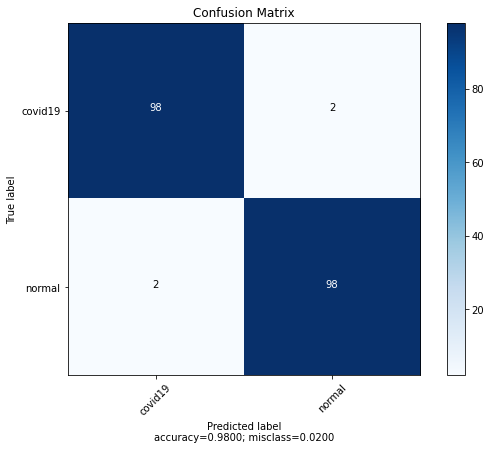

In [88]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [89]:
torch.save(base_model.state_dict(), '/content/drive/My Drive/Dev/densenet_covid_model.pt')

In [90]:
# Loading the model pre-trained weights from saved file
inf_model = CNN_Model(pretrained=False)
inf_model.to(torch.device('cpu'))
inf_model.load_state_dict(torch.load('/content/drive/My Drive/Dev/densenet_covid_model.pt', map_location='cpu'))
inf_model.eval()
print('Inference Model Loaded on CPU')

Inference Model Loaded on CPU


In [91]:
import cv2
from torch.autograd import Variable

In [96]:
#Inference


def predict(img_path):
    image = Image.open(img_path)
    image_tensor = test_transforms(image)
    image_tensor = image_tensor.unsqueeze_(0)
    input = Variable(image_tensor)
    # print(input.shape)
    input = input.to(torch.device('cpu'))
    out = inf_model(input)
    _, preds = torch.max(out, 1)
    idx = preds.cpu().numpy()[0]
    pred_class = class_names[idx]
    score = out[0][0].item()
    plt.imshow(np.array(image))
    print("Predicted: {}".format(pred_class))

Predicted: covid19


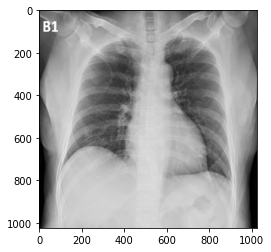

In [97]:
predict('./COVID19-DATASET/test/covid19/COVID-19 (10).png')